## This document is for classify korean text classification with character level and multi embedding

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 2.8MB/s 
     |████████████████████████████████| 2.7MB 33.6MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras import models, layers
from keras.preprocessing import text, sequence
import re
import warnings
import gc
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import plot_model
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from konlpy.tag import Okt

warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/0.Projects/Korean Language Models/petition.csv')

In [4]:
df.head()

,article_id,start,end,answered,votes,category,title,content
0,21,2017-08-19,2017-11-17,0,9,안전/환경,스텔라 데이지호에 대한 제안입니다.,스텔라 데이지호에 대한 제안입니다.\n3월31일 스텔라 데이지호가 침몰하고 5달째가...
1,22,2017-08-19,2017-11-17,0,17,기타,비리제보처를 만들어주세요.,현 정부에 국민들이 가장 원하는 것은 부패척결입니다. 우리 사회에 각종 비리들이 ...
2,23,2017-08-19,2017-09-03,0,0,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ..."
3,24,2017-08-19,2017-08-26,0,53,일자리,공공기관 무조건적인 정규직전환을 반대합니다.,현정부에서 정규직 일자리를 늘리는 것에 찬성합니다. 그런데 공공기관 비정규직들은 인...
4,25,2017-08-19,2017-09-03,0,0,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ..."


In [0]:
df = df.loc[:, ['category', 'title', 'content']]

In [6]:
df.head()

,category,title,content
0,안전/환경,스텔라 데이지호에 대한 제안입니다.,스텔라 데이지호에 대한 제안입니다.\n3월31일 스텔라 데이지호가 침몰하고 5달째가...
1,기타,비리제보처를 만들어주세요.,현 정부에 국민들이 가장 원하는 것은 부패척결입니다. 우리 사회에 각종 비리들이 ...
2,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ..."
3,일자리,공공기관 무조건적인 정규직전환을 반대합니다.,현정부에서 정규직 일자리를 늘리는 것에 찬성합니다. 그런데 공공기관 비정규직들은 인...
4,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ..."


In [0]:
le = LabelEncoder()

df['category_le'] = le.fit_transform(df['category'])

In [8]:
le.classes_

array(['경제민주화', '교통/건축/국토', '기타', '농산어촌', '문화/예술/체육/언론', '미래', '반려동물',
       '보건복지', '성장동력', '안전/환경', '외교/통일/국방', '육아/교육', '인권/성평등', '일자리',
       '저출산/고령화대책', '정치개혁', '행정'], dtype=object)

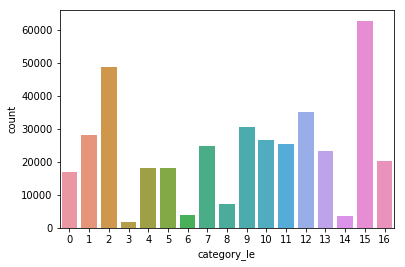

In [9]:
sns.countplot('category_le', data=df)

In [0]:
df.drop('category', axis=1, inplace=True)

In [11]:
df.head()

,title,content,category_le
0,스텔라 데이지호에 대한 제안입니다.,스텔라 데이지호에 대한 제안입니다.\n3월31일 스텔라 데이지호가 침몰하고 5달째가...,9
1,비리제보처를 만들어주세요.,현 정부에 국민들이 가장 원하는 것은 부패척결입니다. 우리 사회에 각종 비리들이 ...,2
2,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ...",5
3,공공기관 무조건적인 정규직전환을 반대합니다.,현정부에서 정규직 일자리를 늘리는 것에 찬성합니다. 그런데 공공기관 비정규직들은 인...,13
4,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ...",5


In [12]:
df.shape

(395547, 3)

In [0]:
# drop duplicated data

df = df.drop_duplicates()

In [14]:
df.shape

(384337, 3)

In [15]:
df.head()

,title,content,category_le
0,스텔라 데이지호에 대한 제안입니다.,스텔라 데이지호에 대한 제안입니다.\n3월31일 스텔라 데이지호가 침몰하고 5달째가...,9
1,비리제보처를 만들어주세요.,현 정부에 국민들이 가장 원하는 것은 부패척결입니다. 우리 사회에 각종 비리들이 ...,2
2,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ...",5
3,공공기관 무조건적인 정규직전환을 반대합니다.,현정부에서 정규직 일자리를 늘리는 것에 찬성합니다. 그런데 공공기관 비정규직들은 인...,13
5,보건복지부 부령 제339호중 “특수의료장비 운영에 관한 규칙” 중 불합리한 행정제...,청원인 왕 기 운\n서울 도봉구 창동 삼성아파트 101-1103호\n청원취지\n보...,7


In [0]:
x_train, x_test, y_train, y_test = train_test_split(df[['title', 'content']], df['category_le'], test_size=0.8, stratify=df['category_le'], random_state=1228)

In [0]:
target = y_train.copy()
text_data = x_train.copy()

In [18]:
display(target.head())
display(text_data.head())

print(target.shape)
print(text_data.shape)

360898    13
192078    15
201664    15
326896    16
307201    12
Name: category_le, dtype: int64

,title,content
360898,최처임금을 높여주세요,최저임금이란 법으로써 근로자의 최소한의 의식주를 보장하는 제도를 일컫습니다\n그런데...
192078,국회법을 사법부 행정부 입법부가 모여서 만들었으면 합니다,제가 무식해서 잘은 모르지만 국회법을 국회의원이 스스로 만든다는걸 들었습니다\n이번...
201664,청소년 보호하는법을 없애주세요,청소년들이 보호받는 법이 있습니다 그런데 아무것도 모른채 범하는 친구들은 괜찮지만 ...
326896,IDS 홀딩스 피해금액 보상을 끝까지 요구합니다!,"링크된 것과 같이 IDS 홀딩스에 대한 내용입니다. 검색만 해봐도, 관련된 내용이..."
307201,인생박살난 교수님 천안 D대,얼마 전 몇몇 무리들이 제가 재학중인 학교 교수님을\n교수직 자리에서 끌어내고ㅡ 그...


(76867,)
(76867, 2)


In [0]:
del x_test
del y_test
del x_train
del y_train

In [20]:
gc.collect()

123

In [0]:
target = target.reset_index()
text_data = text_data.reset_index()

In [0]:
target.drop('index',axis=1, inplace=True)
text_data.drop('index',axis=1, inplace=True)

In [23]:
display(target.head())
display(text_data.head())

print(target.shape)
print(text_data.shape)

,category_le
0,13
1,15
2,15
3,16
4,12


,title,content
0,최처임금을 높여주세요,최저임금이란 법으로써 근로자의 최소한의 의식주를 보장하는 제도를 일컫습니다\n그런데...
1,국회법을 사법부 행정부 입법부가 모여서 만들었으면 합니다,제가 무식해서 잘은 모르지만 국회법을 국회의원이 스스로 만든다는걸 들었습니다\n이번...
2,청소년 보호하는법을 없애주세요,청소년들이 보호받는 법이 있습니다 그런데 아무것도 모른채 범하는 친구들은 괜찮지만 ...
3,IDS 홀딩스 피해금액 보상을 끝까지 요구합니다!,"링크된 것과 같이 IDS 홀딩스에 대한 내용입니다. 검색만 해봐도, 관련된 내용이..."
4,인생박살난 교수님 천안 D대,얼마 전 몇몇 무리들이 제가 재학중인 학교 교수님을\n교수직 자리에서 끌어내고ㅡ 그...


(76867, 1)
(76867, 2)


In [0]:
text_data['concat'] = text_data['title'] + text_data['content']

In [25]:
text_data.head()

,title,content,concat
0,최처임금을 높여주세요,최저임금이란 법으로써 근로자의 최소한의 의식주를 보장하는 제도를 일컫습니다\n그런데...,최처임금을 높여주세요최저임금이란 법으로써 근로자의 최소한의 의식주를 보장하는 제도를...
1,국회법을 사법부 행정부 입법부가 모여서 만들었으면 합니다,제가 무식해서 잘은 모르지만 국회법을 국회의원이 스스로 만든다는걸 들었습니다\n이번...,국회법을 사법부 행정부 입법부가 모여서 만들었으면 합니다제가 무식해서 잘은 모르지만...
2,청소년 보호하는법을 없애주세요,청소년들이 보호받는 법이 있습니다 그런데 아무것도 모른채 범하는 친구들은 괜찮지만 ...,청소년 보호하는법을 없애주세요청소년들이 보호받는 법이 있습니다 그런데 아무것도 모른...
3,IDS 홀딩스 피해금액 보상을 끝까지 요구합니다!,"링크된 것과 같이 IDS 홀딩스에 대한 내용입니다. 검색만 해봐도, 관련된 내용이...",IDS 홀딩스 피해금액 보상을 끝까지 요구합니다!링크된 것과 같이 IDS 홀딩스에 ...
4,인생박살난 교수님 천안 D대,얼마 전 몇몇 무리들이 제가 재학중인 학교 교수님을\n교수직 자리에서 끌어내고ㅡ 그...,인생박살난 교수님 천안 D대얼마 전 몇몇 무리들이 제가 재학중인 학교 교수님을\n교...


In [26]:
gc.collect()

40

In [0]:
only_text = pd.DataFrame(text_data['concat'])

In [0]:
del text_data

In [29]:
only_text.head()

,concat
0,최처임금을 높여주세요최저임금이란 법으로써 근로자의 최소한의 의식주를 보장하는 제도를...
1,국회법을 사법부 행정부 입법부가 모여서 만들었으면 합니다제가 무식해서 잘은 모르지만...
2,청소년 보호하는법을 없애주세요청소년들이 보호받는 법이 있습니다 그런데 아무것도 모른...
3,IDS 홀딩스 피해금액 보상을 끝까지 요구합니다!링크된 것과 같이 IDS 홀딩스에 ...
4,인생박살난 교수님 천안 D대얼마 전 몇몇 무리들이 제가 재학중인 학교 교수님을\n교...


In [30]:
only_text.iloc[0, :].values

array(['최처임금을 높여주세요최저임금이란 법으로써 근로자의 최소한의 의식주를 보장하는 제도를 일컫습니다\\n그런데 1인이 한시간을 일해서 고작8000원을 받는다?\\n이는 도저히 사람으로써의 기본적인 의식주를 해결하기위해서는 턱없이 부족합니다\\n유럽의 선진국들의 사례를 보더라도 우리의 최저시급이 얼마나 낮은지를 금방 알수있습니다\\n일단 최저임금 최초 시행국가인 뉴질래드의 경우 최저시급이 한화 12054원을 받습니다\\n그외에도 노르웨이 22000원, 프랑스 14013원, 독일 12250원, 영국 11381원, 호주 15000원 이상,\\n미국 뉴욕주는 16965원으로 정해놓았습니다\\n이처럼 유럽의 대부분의 나라가 최저시급이 10000원을 넘고\\n노르웨이의 경우 20000원이 넘기고 있습니다\\n이를 본받아 우리 또한 최저시급을 적어도 10000원을  넘게 하는 것이\\n근로자의 최소한의 의식주를 보장할수 있을겁니다'],
      dtype=object)

In [0]:
def remove_punct(x):
  strip = str(x).strip()
  pattern_n = re.compile('\\\\n')
  result = re.sub(pattern_n, ' ', strip)
  
  pattern_puct = re.compile('[^가-힣a-zA-Z0-9]+')
  result = re.sub(pattern_puct, ' ', result)
  return result 

In [0]:
brief_preprocess = only_text['concat'].apply(remove_punct)

In [33]:
del only_text
gc.collect()

184

In [34]:
brief_preprocess.head()

0    최처임금을 높여주세요최저임금이란 법으로써 근로자의 최소한의 의식주를 보장하는 제도를...
1    국회법을 사법부 행정부 입법부가 모여서 만들었으면 합니다제가 무식해서 잘은 모르지만...
2    청소년 보호하는법을 없애주세요청소년들이 보호받는 법이 있습니다 그런데 아무것도 모른...
3    IDS 홀딩스 피해금액 보상을 끝까지 요구합니다 링크된 것과 같이 IDS 홀딩스에 ...
4    인생박살난 교수님 천안 D대얼마 전 몇몇 무리들이 제가 재학중인 학교 교수님을 교수...
Name: concat, dtype: object

In [35]:
brief_preprocess

0        최처임금을 높여주세요최저임금이란 법으로써 근로자의 최소한의 의식주를 보장하는 제도를...
1        국회법을 사법부 행정부 입법부가 모여서 만들었으면 합니다제가 무식해서 잘은 모르지만...
2        청소년 보호하는법을 없애주세요청소년들이 보호받는 법이 있습니다 그런데 아무것도 모른...
3        IDS 홀딩스 피해금액 보상을 끝까지 요구합니다 링크된 것과 같이 IDS 홀딩스에 ...
4        인생박살난 교수님 천안 D대얼마 전 몇몇 무리들이 제가 재학중인 학교 교수님을 교수...
5        가상화폐거래소 폐쇄에 대한 법무부 장관님의 의견에 반대합니다 존경하는 대통령님 방금...
6        장애인 자립생활 실현을 위하여장애인 자립생활 실현을 위하여 자립생활가정 지원사업 지...
7        사법조폭 국민 혁명으로 제거하라 무장봉기하라 군부 힘을 빌리든가 판사 변호사 유착 ...
8        촌에 사는 주민의 목소리는 지나가는 개가짖는 소리보다 가치가 없는걸까요 안녕합십니까...
9        문정부 사찰유전자 내로남불 차고 넘치는거 같다 변명하고 덮으면 또 다른게 불거지고 ...
10       징병군인 기본권 통제한 만큼 고통분담금 지급하라문재인 니는 스스로 청와대 들어간거고...
11       국회의원 최저인금 국민들 더이상 참지 못한다 재요청지금 저는 청와대 국민청원을 하고...
12       401호 앞에 중부오안이라는 업체차가 있었습니다해킹 대비와 보안 해킹했다면 강력한 ...
13       충남 천안 주폭 운전자들 단속안하나요 충남 천안에 살고있는 시민입니다 천안시에는 어...
14       아청법 제 2조 5항을 개정해주세요아동 청소년을 보호한다는 법의 취지는 좋은 일이고...
15       무슬림추방 불체자추방 난민추방 외노자추방우리국민은 의무만 지고 권리는 이들이 모두 ...
16       상여금을 돌려주세요2018년 최저 임금 인상으로 기업에서 상여금을 없애고 있습니다 .

In [0]:
def remove_multispace(x):
  x = x.lstrip()
  x = x.rstrip()
  x = x.strip()
  pattern = re.compile('[\s]+')
  result = re.sub(pattern, ' ', x)
  return result

In [0]:
brief_preprocess = brief_preprocess.apply(remove_multispace)

In [38]:
brief_preprocess.head()

0    최처임금을 높여주세요최저임금이란 법으로써 근로자의 최소한의 의식주를 보장하는 제도를...
1    국회법을 사법부 행정부 입법부가 모여서 만들었으면 합니다제가 무식해서 잘은 모르지만...
2    청소년 보호하는법을 없애주세요청소년들이 보호받는 법이 있습니다 그런데 아무것도 모른...
3    IDS 홀딩스 피해금액 보상을 끝까지 요구합니다 링크된 것과 같이 IDS 홀딩스에 ...
4    인생박살난 교수님 천안 D대얼마 전 몇몇 무리들이 제가 재학중인 학교 교수님을 교수...
Name: concat, dtype: object

In [0]:
brief_preprocess = pd.DataFrame(brief_preprocess)

In [40]:
brief_preprocess.head()

,concat
0,최처임금을 높여주세요최저임금이란 법으로써 근로자의 최소한의 의식주를 보장하는 제도를...
1,국회법을 사법부 행정부 입법부가 모여서 만들었으면 합니다제가 무식해서 잘은 모르지만...
2,청소년 보호하는법을 없애주세요청소년들이 보호받는 법이 있습니다 그런데 아무것도 모른...
3,IDS 홀딩스 피해금액 보상을 끝까지 요구합니다 링크된 것과 같이 IDS 홀딩스에 ...
4,인생박살난 교수님 천안 D대얼마 전 몇몇 무리들이 제가 재학중인 학교 교수님을 교수...


In [42]:
okt = Okt()

okt.pos(brief_preprocess['concat'][0], norm=True, join=True)

['최처/Noun',
 '임금/Noun',
 '을/Josa',
 '높여주세요/Verb',
 '최저임금/Noun',
 '이란/Josa',
 '법/Noun',
 '으로써/Josa',
 '근로자/Noun',
 '의/Josa',
 '최소한/Noun',
 '의/Josa',
 '의식주/Noun',
 '를/Josa',
 '보장/Noun',
 '하는/Verb',
 '제도/Noun',
 '를/Josa',
 '일컫습니다/Verb',
 '그런데/Conjunction',
 '1/Number',
 '인/Noun',
 '이/Josa',
 '한/Determiner',
 '시간/Noun',
 '을/Josa',
 '일해/Noun',
 '서/Josa',
 '고작/Noun',
 '8000원/Number',
 '을/Foreign',
 '받는다/Verb',
 '이는/Verb',
 '도저히/Noun',
 '사람/Noun',
 '으로써/Josa',
 '의/Noun',
 '기본/Noun',
 '적/Suffix',
 '인/Josa',
 '의식주/Noun',
 '를/Josa',
 '해결/Noun',
 '하기/Verb',
 '위해/Noun',
 '서는/Verb',
 '턱/Noun',
 '없이/Adverb',
 '부족합니다/Adjective',
 '유럽/Noun',
 '의/Josa',
 '선진국/Noun',
 '들/Suffix',
 '의/Josa',
 '사례/Noun',
 '를/Josa',
 '보더/Noun',
 '라도/Josa',
 '우리/Noun',
 '의/Josa',
 '최저/Noun',
 '시급/Noun',
 '이/Josa',
 '얼마나/Noun',
 '낮은지를/Adjective',
 '금방/Noun',
 '알수있습니다/Verb',
 '일단/Noun',
 '최저임금/Noun',
 '최초/Noun',
 '시행/Noun',
 '국가/Noun',
 '인/Josa',
 '뉴질래드/Noun',
 '의/Josa',
 '경우/Noun',
 '최저/Noun',
 '시급/Noun',
 '이/Josa',
 '한화/Nou

In [0]:
def okt_morph(x):
  return okt.pos(x, norm=True, join=True)

In [0]:
brief_preprocess['split'] = brief_preprocess['concat'].apply(okt_morph)

In [0]:
# # 초성 리스트. 00 ~ 18
# CHOSUNG_LIST = ['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']
# # 중성 리스트. 00 ~ 20
# JUNGSUNG_LIST = ['ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅚ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ']
# # 종성 리스트. 00 ~ 27 + 1(1개 없음)
# JONGSUNG_LIST = ['*', 'ㄱ', 'ㄲ', 'ㄳ', 'ㄴ', 'ㄵ', 'ㄶ', 'ㄷ', 'ㄹ', 'ㄺ', 'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 'ㅁ', 'ㅂ', 'ㅄ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']
# ALPHABET_LIST = ['A', 'B', 'C', 'D', 'E','F','G','H','I','J','K','L','N','M','O','P','Q','R','S','T','U','V','W','X','Y','Z']
# NUMBER_LIST = ['0','1','2','3','4','5','6','7','8','9']


# def korean_to_be_split(korean_word):
#     r_lst = []
#     for w in list(korean_word.strip()):
#         ## 영어인 경우 구분해서 작성함. 
#         if '가'<=w<='힣':
#             ## 588개 마다 초성이 바뀜. 
#             ch1 = (ord(w) - ord('가'))//588
#             ## 중성은 총 28가지 종류
#             ch2 = ((ord(w) - ord('가')) - (588*ch1)) // 28
#             ch3 = (ord(w) - ord('가')) - (588*ch1) - 28*ch2
#             r_lst.append(CHOSUNG_LIST[ch1])
#             r_lst.append(JUNGSUNG_LIST[ch2])
#             r_lst.append(JONGSUNG_LIST[ch3])
#         else:
#             r_lst.append(w)
#     return r_lst

In [0]:
# brief_preprocess['split'] = brief_preprocess['concat'].apply(korean_to_be_split)

In [42]:
# brief_preprocess.head()

,concat,split
0,최처임금을 높여주세요최저임금이란 법으로써 근로자의 최소한의 의식주를 보장하는 제도를...,"[ㅊ, ㅚ, *, ㅊ, ㅓ, *, ㅇ, ㅣ, ㅁ, ㄱ, ㅡ, ㅁ, ㅇ, ㅡ, ㄹ, ..."
1,국회법을 사법부 행정부 입법부가 모여서 만들었으면 합니다제가 무식해서 잘은 모르지만...,"[ㄱ, ㅜ, ㄱ, ㅎ, ㅚ, *, ㅂ, ㅓ, ㅂ, ㅇ, ㅡ, ㄹ, , ㅅ, ㅏ, ..."
2,청소년 보호하는법을 없애주세요청소년들이 보호받는 법이 있습니다 그런데 아무것도 모른...,"[ㅊ, ㅓ, ㅇ, ㅅ, ㅗ, *, ㄴ, ㅕ, ㄴ, , ㅂ, ㅗ, *, ㅎ, ㅗ, ..."
3,IDS 홀딩스 피해금액 보상을 끝까지 요구합니다 링크된 것과 같이 IDS 홀딩스에 ...,"[I, D, S, , ㅎ, ㅗ, ㄹ, ㄷ, ㅣ, ㅇ, ㅅ, ㅡ, *, , ㅍ, ..."
4,인생박살난 교수님 천안 D대얼마 전 몇몇 무리들이 제가 재학중인 학교 교수님을 교수...,"[ㅇ, ㅣ, ㄴ, ㅅ, ㅐ, ㅇ, ㅂ, ㅏ, ㄱ, ㅅ, ㅏ, ㄹ, ㄴ, ㅏ, ㄴ, ..."


In [43]:
# brief_preprocess['split'].head()

0    [ㅊ, ㅚ, *, ㅊ, ㅓ, *, ㅇ, ㅣ, ㅁ, ㄱ, ㅡ, ㅁ, ㅇ, ㅡ, ㄹ, ...
1    [ㄱ, ㅜ, ㄱ, ㅎ, ㅚ, *, ㅂ, ㅓ, ㅂ, ㅇ, ㅡ, ㄹ,  , ㅅ, ㅏ, ...
2    [ㅊ, ㅓ, ㅇ, ㅅ, ㅗ, *, ㄴ, ㅕ, ㄴ,  , ㅂ, ㅗ, *, ㅎ, ㅗ, ...
3    [I, D, S,  , ㅎ, ㅗ, ㄹ, ㄷ, ㅣ, ㅇ, ㅅ, ㅡ, *,  , ㅍ, ...
4    [ㅇ, ㅣ, ㄴ, ㅅ, ㅐ, ㅇ, ㅂ, ㅏ, ㄱ, ㅅ, ㅏ, ㄹ, ㄴ, ㅏ, ㄴ, ...
Name: split, dtype: object

In [0]:
# full_text = brief_preprocess['split'].tolist() + CHOSUNG_LIST + JUNGSUNG_LIST + JONGSUNG_LIST + ALPHABET_LIST + NUMBER_LIST

In [45]:
# full_text

Output hidden; open in https://colab.research.google.com to view.

In [0]:
token = text.Tokenizer(filters='', split=',', char_level=True)

In [0]:
token.fit_on_texts(full_text)

In [48]:
token.index_word

{1: '*',
 2: ' ',
 3: 'ㅇ',
 4: 'ㄴ',
 5: 'ㅏ',
 6: 'ㄱ',
 7: 'ㅣ',
 8: 'ㄹ',
 9: 'ㅡ',
 10: 'ㅅ',
 11: 'ㅓ',
 12: 'ㅗ',
 13: 'ㄷ',
 14: 'ㅈ',
 15: 'ㅎ',
 16: 'ㅁ',
 17: 'ㅂ',
 18: 'ㅜ',
 19: 'ㅐ',
 20: 'ㅕ',
 21: 'ㅔ',
 22: 'ㅊ',
 23: 'ㅆ',
 24: 'ㅘ',
 25: 'ㅛ',
 26: 'ㅌ',
 27: 'ㅢ',
 28: 'ㅚ',
 29: 'ㅍ',
 30: 'ㅝ',
 31: 'ㅑ',
 32: 'ㄲ',
 33: 'ㅠ',
 34: 'ㅟ',
 35: 'ㄸ',
 36: 'ㅖ',
 37: '0',
 38: '1',
 39: 'ㄶ',
 40: 'ㅄ',
 41: 'ㅋ',
 42: '2',
 43: '3',
 44: '5',
 45: 'ㅃ',
 46: 'ㅉ',
 47: '4',
 48: 'ㅙ',
 49: '8',
 50: 't',
 51: '6',
 52: '7',
 53: '9',
 54: 'e',
 55: 's',
 56: 'o',
 57: 'a',
 58: 'i',
 59: 'c',
 60: 'n',
 61: 'm',
 62: 'r',
 63: 'p',
 64: 'd',
 65: 'h',
 66: 'w',
 67: 'b',
 68: 'l',
 69: 'ㄺ',
 70: 'k',
 71: 'ㄻ',
 72: 'g',
 73: 'ㅀ',
 74: 'v',
 75: 'u',
 76: 'f',
 77: 'ㅒ',
 78: 'x',
 79: 'y',
 80: 'ㅞ',
 81: 'ㄼ',
 82: 'j',
 83: 'ㄵ',
 84: 'q',
 85: 'z',
 86: 'ㄳ',
 87: 'ㄾ',
 88: 'ㄿ',
 89: 'ㄽ'}

In [49]:
brief_preprocess['split'].head()

0    [ㅊ, ㅚ, *, ㅊ, ㅓ, *, ㅇ, ㅣ, ㅁ, ㄱ, ㅡ, ㅁ, ㅇ, ㅡ, ㄹ, ...
1    [ㄱ, ㅜ, ㄱ, ㅎ, ㅚ, *, ㅂ, ㅓ, ㅂ, ㅇ, ㅡ, ㄹ,  , ㅅ, ㅏ, ...
2    [ㅊ, ㅓ, ㅇ, ㅅ, ㅗ, *, ㄴ, ㅕ, ㄴ,  , ㅂ, ㅗ, *, ㅎ, ㅗ, ...
3    [I, D, S,  , ㅎ, ㅗ, ㄹ, ㄷ, ㅣ, ㅇ, ㅅ, ㅡ, *,  , ㅍ, ...
4    [ㅇ, ㅣ, ㄴ, ㅅ, ㅐ, ㅇ, ㅂ, ㅏ, ㄱ, ㅅ, ㅏ, ㄹ, ㄴ, ㅏ, ㄴ, ...
Name: split, dtype: object

In [0]:
text_index = token.texts_to_sequences(brief_preprocess['split'].values)

In [51]:
# check max len

max_len_checker = []
for i in text_index:
  result =len(i)
#   print(result)
  max_len_checker.append(result)

np.max(np.array(max_len_checker))

170396

In [0]:
text_pad = sequence.pad_sequences(text_index, 150000, padding='pre', dtype=np.uint8)

In [0]:
del brief_preprocess

In [54]:
gc.collect()

136

In [0]:
target = target.values

In [0]:
target = to_categorical(target)

In [57]:
gc.collect()

7

In [58]:
print(text_pad.shape)
print(target.shape)

(76867, 150000)
(76867, 17)


In [59]:
gc.collect()

0

In [0]:
x_train, x_test , y_train, y_test = train_test_split(text_pad, target, test_size=0.3, stratify=target, random_state=1228)

In [61]:
print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

(53806, 150000)
(23061, 150000)
(53806, 17)
(23061, 17)


In [0]:
del text_pad

In [0]:
max_len = len(token.index_word)

In [64]:
from keras import backend as K
import keras

input_tensor = keras.layers.Input(shape = (150000, ))

x_emb = keras.layers.Embedding(max_len+1, 300)(input_tensor)
x = keras.layers.SpatialDropout1D(0.4)(x_emb)
x_1 = keras.layers.Conv1D(64, 3, padding='same', activation='relu', strides=3)(x)
x_1 = keras.layers.BatchNormalization()(x_1)
# x_1 = keras.layers.Conv1D(256, 3, padding='same', activation='relu')(x_1)
x_1_1 = keras.layers.MaxPool1D()(x_1)
x_1_2 = keras.layers.AvgPool1D()(x_1)
concat_x_1 = keras.layers.Concatenate()([x_1_1, x_1_2])

x_2 = keras.layers.Conv1D(64, 5, padding='same', activation='relu',strides=3)(x)
x_2 = keras.layers.BatchNormalization()(x_2)
# x_2 = keras.layers.Conv1D(256, 5, padding='same', activation='relu')(x_2)
x_2_1 = keras.layers.MaxPool1D()(x_2)
x_2_2 = keras.layers.AvgPool1D()(x_2)
concat_x_2 = keras.layers.Concatenate()([x_2_1, x_2_2])

x_3 = keras.layers.Conv1D(64, 7, padding='same', activation='relu',strides=3)(x)
x_3 = keras.layers.BatchNormalization()(x_3)
# x_3 = keras.layers.Conv1D(256, 7, padding='same', activation='relu')(x_3)
x_3_1 = keras.layers.MaxPool1D()(x_3)
x_3_2 = keras.layers.AvgPool1D()(x_3)
concat_x_3 = keras.layers.Concatenate()([x_3_1, x_3_2])

x_4 = keras.layers.Conv1D(64, 9, padding='same', activation='relu',strides=3)(x)
x_4 = keras.layers.BatchNormalization()(x_4)
# x_4 = keras.layers.Conv1D(256, 10, padding='same', activation='relu')(x_4)
x_4_1 = keras.layers.MaxPool1D()(x_4)
x_4_2 = keras.layers.AvgPool1D()(x_4)
concat_x_4 = keras.layers.Concatenate()([x_4_1, x_4_2])

x_5 = keras.layers.Conv1D(64, 12, padding='same', activation='relu',strides=3)(x)
x_5 = keras.layers.BatchNormalization()(x_5)
# x_5 = keras.layers.Conv1D(256, 1, padding='same', activation='relu')(x_5)
x_5_1 = keras.layers.MaxPool1D()(x_5)
x_5_2 = keras.layers.AvgPool1D()(x_5)
concat_x_5 = keras.layers.Concatenate()([x_5_1, x_5_2])

concat = keras.layers.Concatenate()([concat_x_1, concat_x_2, concat_x_3, concat_x_4, concat_x_5])

x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(concat)

x_1 = layers.GlobalAvgPool1D()(x)
x_2 = layers.GlobalMaxPool1D()(x)
x = layers.Concatenate()([x_1, x_2])

x_out = keras.layers.Dense(256, activation='relu')(x)
x_out = keras.layers.BatchNormalization()(x_out)
x_out = keras.layers.Dense(128, activation='relu')(x_out)
x_out = keras.layers.BatchNormalization()(x_out)
x_out = keras.layers.Dense(128, activation='relu')(x_out)
output = keras.layers.Dense(17, activation='softmax')(x_out)



model = keras.models.Model(input_tensor, output)

opt = keras.optimizers.adam(lr = 0.01, beta_1=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# my_call_rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, verbose=1)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.






In [66]:
history = model.fit(x_train, y_train, batch_size=8, epochs=100, validation_data =(x_test, y_test))

Train on 53806 samples, validate on 23061 samples
Epoch 1/100


ResourceExhaustedError: ignored